In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
%matplotlib inline 
plt.style.use("ggplot")
## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'


## Setup
class CFG:
  batch_size = 1024
  num_epochs = 10
  workers = 4
  seed = 2021
  image_size = 64
  img_folder = f'{dataset_folder}/img_align_celeba'
  nc = 3 ## number chanels
  ngf = 64 #Size of feature maps in generator
  nz = 100 #latent random input vector
  ndf = 64 #Size of feature maps in discriminator
  lr = 0.0002
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  sample_dir = "/content/images/"

if not os.path.exists(CFG.sample_dir):
  os.makedirs(CFG.sample_dir)

if torch.cuda.is_available():
  !nvidia-smi

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

  # Download the dataset from google drive
  gdown.download(url, download_path, quiet=False)

  # Unzip the downloaded file 
  with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)
    return img

transform=transforms.Compose([
    transforms.Resize(CFG.image_size),
    transforms.CenterCrop(CFG.image_size),
    transforms.ToTensor()   
])

## Create a dataset, dataloader 

Wed Jul 28 11:04:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
1.44GB [00:21, 67.7MB/s]


In [ ]:
### return the shape of image
dataset[0].shape

torch.Size([3, 64, 64])

(array([ 9., 37., 16., 38.,  0.,  0.,  0.,  0.,  0.,  2., 95.,  3.,  0.,
         5., 95.]),
 array([0.7921569 , 0.8060131 , 0.8198693 , 0.8337255 , 0.8475817 ,
        0.8614379 , 0.87529415, 0.8891503 , 0.90300655, 0.9168627 ,
        0.93071896, 0.9445752 , 0.95843136, 0.9722876 , 0.98614377,
        1.        ], dtype=float32),
 <a list of 15 Patch objects>)

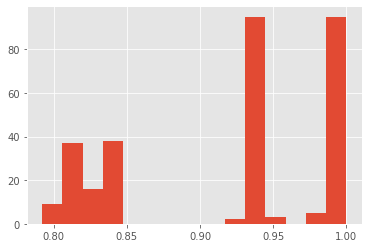

In [ ]:
### Plot the histogram of images's value
img = dataset[0]
plt.hist(img[:,5:15,5:15].flatten(), bins=15)

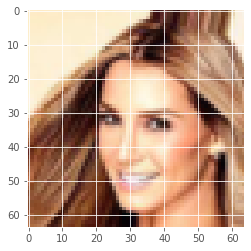

In [ ]:
# show the images with matplotlib

## Define the model

- Generator network
![generator](https://github.com/manhlab/practike-gan-2021/blob/main/06-cDcGAN-celebA-metrics/generator.png?raw=true)

- Discrimator network
![discrimator](https://github.com/manhlab/practike-gan-2021/blob/main/06-cDcGAN-celebA-metrics/discrimator.png?raw=true)

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
import torch.nn as nn
# Generator 
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        # ConvTranspose2d nz ngf * 8
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf * 8 ngf * 4
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf * 4 ngf * 2
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf * 2 ngf  
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf  nc
        # Sigmoid

    def forward(self, input):

# Discriminator 

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        # SpectralNorm Conv2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # Sigmoid
    def forward(self, input):


In [ ]:
# Create model: Generator and Discriminator

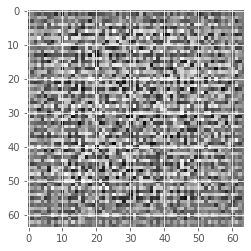

In [ ]:
# test the generator: create random vector to fit the networks, then show the result with matplotlib
input = torch.randn(2, CFG.nz , 1 , 1)

In [ ]:
from torchsummary import summary
D.to(CFG.device)
summary(D, input_size=(3, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      SpectralNorm-1           [-1, 64, 32, 32]               0
         LeakyReLU-2           [-1, 64, 32, 32]               0
      SpectralNorm-3          [-1, 128, 16, 16]               0
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
      SpectralNorm-6            [-1, 256, 8, 8]               0
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
      SpectralNorm-9            [-1, 512, 4, 4]               0
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
     SpectralNorm-12              [-1, 1, 1, 1]               0
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 1,792
Trainable params: 1

In [ ]:
## define the loss, and optimizers for generator and discrimator networks

In [ ]:
# reset the generator and discrimator gradient's optimizers to zero. 
def reset_grad():


#train the discrimator like the graphic
def train_discriminator(images): 
    # Loss for real images
    outputs = D(images).view(-1)
    real_labels = torch.ones(outputs.shape[0]).to(CFG.device)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(z)
    outputs = D(fake_images).view(-1)
    fake_labels = torch.zeros(outputs.shape[0]).to(CFG.device)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    # Reset gradients
    # Compute gradients
    # Adjust the parameters using backprop
    
    return d_loss, real_score, fake_score

In [ ]:
#train the generator like graphic
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(CFG.batch_size, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(z)
    labels = torch.ones(fake_images.shape[0]).to(CFG.device)
    g_loss = criterion(D(fake_images).view(-1), labels)

    # Backprop and optimize
    return g_loss, fake_images

In [ ]:
# save some photo to show the result
def save_fake_images(index):
    sample_vectors = torch.randn(10, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    # start the training loop (dataloader)
    for i, (images) in enumerate(dataloader):
        images = images.to(CFG.device)
        
        # Train the discriminator and generator

        
        # Inspect the losses
        if (i+1) % 50 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, CFG.num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [50/198], d_loss: 0.0612, g_loss: 8.1332, D(x): 0.98, D(G(z)): 0.03
Epoch [0/10], Step [100/198], d_loss: 0.0693, g_loss: 7.5388, D(x): 0.97, D(G(z)): 0.01
Epoch [0/10], Step [150/198], d_loss: 0.0335, g_loss: 8.1203, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/10], Step [50/198], d_loss: 0.0180, g_loss: 8.4989, D(x): 0.99, D(G(z)): 0.01
Epoch [1/10], Step [100/198], d_loss: 0.0119, g_loss: 8.2249, D(x): 0.99, D(G(z)): 0.00
Epoch [1/10], Step [150/198], d_loss: 0.0182, g_loss: 10.6233, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/10], Step [50/198], d_loss: 0.0073, g_loss: 9.3846, D(x): 1.00, D(G(z)): 0.00
Epoch [2/10], Step [100/198], d_loss: 0.0112, g_loss: 8.5831, D(x): 1.00, D(G(z)): 0.01
Epoch [2/10], Step [150/198], d_loss: 0.1206, g_loss: 4.1188, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/10], Step [50/198], d_loss: 0.0589, g_loss: 10.1914, D(x): 0.99, D(G(z)): 0.04
Epoch [3/10], Step [100/198], d_loss: 

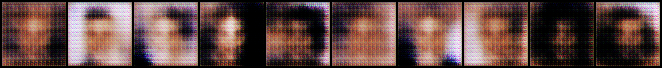

In [ ]:
from PIL import Image
#show result/image
Image.open('images/fake_images-0010.png')

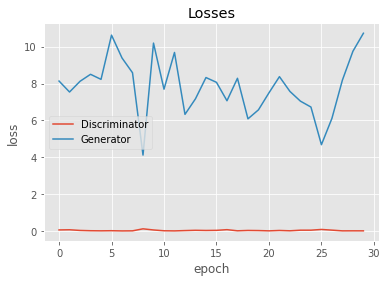

In [ ]:
# plot the loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

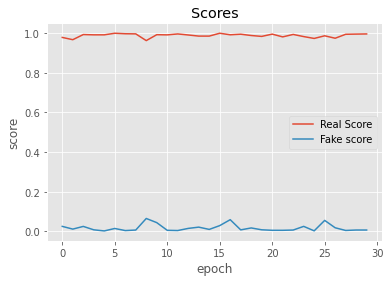

In [ ]:
# plot the score
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [ ]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 138 (delta 70), reused 114 (delta 46), pack-reused 0
Receiving objects: 100% (138/138), 42.06 KiB | 14.02 MiB/s, done.
Resolving deltas: 100% (70/70), done.
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Follow the repo's instruction


In [ ]:
%cd /content/pytorch_gan_metrics
#### Prepare Statistics for FID


[Errno 2] No such file or directory: '/content/pytorch_gan_metrics'
/content
Downloading: "https://github.com/w86763777/pytorch-gan-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:03<00:00, 28.0MB/s]
tcmalloc: large alloc 3319382016 bytes == 0x5636695d6000 @  0x7f7c547141e7 0x7f7c5225446e 0x7f7c522a4c7b 0x7f7c522a535f 0x7f7c52347103 0x5635cb663010 0x5635cb662da0 0x5635cb6d72f9 0x5635cb6d1dcc 0x5635cb66473a 0x5635cb6d2b0e 0x5635cb6d2235 0x5635cb66473a 0x5635cb6d393b 0x5635cb6d1c35 0x5635cb6d1933 0x5635cb6cfda0 0x5635cb662ea9 0x5635cb662da0 0x5635cb6d6bb3 0x5635cb6d1c35 0x5635cb66473a 0x5635cb6d2b0e 0x5635cb6d1c35 0x5635cb5a3eb1 0x5635cb775731 0x5635cb77334a 0x5635cb772fbc 0x7f7c534febf7 0x5635cb772e9a
get_inception_feature:   0% 0/202599 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated

#### calculate the Inception Score (IS) and Fréchet Inception Distance (FID)

In [ ]:
# import function from pytorch_gan_metrics 
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 500
    
    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

# define dataset
#create dataloader

# Inception Score
# Frechet Inception Distance
# Inception Score + Frechet Inception Distance


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# print the result


Inception Score: 1.5099082923543354 (std:0.04970984863443799)
Fréchet Inception Distance: 379.9139737392042


## Geometry Score
from this repo: https://github.com/KhrulkovV/geometry-score
It is a novel measure of performance of a GAN by comparing geometrical properties of the underlying data manifold and the generated one, which provides both qualitative and quantitative means for evaluation. 

![Geometry Score](https://github.com/KhrulkovV/geometry-score/blob/master/assets/manif.png?raw=true)

In [ ]:
%cd /content
!git clone https://github.com/KhrulkovV/geometry-score.git

/content
Cloning into 'geometry-score'...
remote: Enumerating objects: 114, done.
remote: Total 114 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (114/114), 4.01 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
!pip install gudhi

     |████████████████████████████████| 28.2 MB 1.3 MB/s 


In [ ]:
import sys 
sys.path.insert(0, "/content/geometry-score")
import gs
for i, (images) in enumerate(dataloader):
  x = images.numpy()
  break
print(x.shape)
x = np.reshape(x, (-1, 3*64*64))
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

(1024, 3, 64, 64)
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


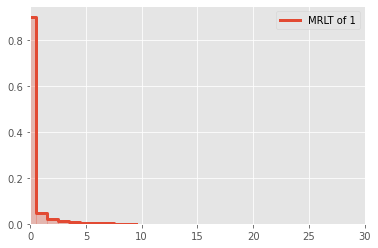

In [ ]:
mrlt = np.mean(rltx, axis=0)
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [ ]:
dataset = GeneratorDataset(G,  CFG.nz)
loader = torch.utils.data.DataLoader(dataset, batch_size=CFG.batch_size, num_workers=0)
for i, (images) in enumerate(loader):
  x = images.detach().cpu().numpy()
  break
print(x.shape)
x = np.reshape(x, (-1, 3*64*64))
rlty = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

(500, 3, 64, 64)
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


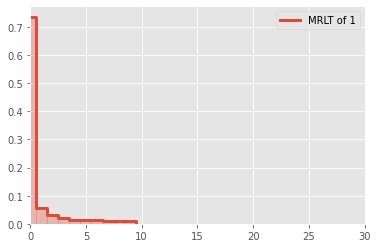

In [ ]:
mrlt = np.mean(rlty, axis=0)
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [ ]:
# Compute score


Geometry Score: 0.028550751609483373


## Model 2 score: Add more layers

In [ ]:
# Define new networks: double the size with CFG.nfg*2 and CFG.ndf*2
#define the loss and optimizer

In [ ]:
%%time

total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images) in enumerate(dataloader):
        images = images.to(CFG.device)
        # Train the discriminator and generator
        # Inspect the losses
        if (i+1) % 50 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, CFG.num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [50/198], d_loss: 1.2385, g_loss: 8.3068, D(x): 0.76, D(G(z)): 0.08
Epoch [0/10], Step [100/198], d_loss: 0.2556, g_loss: 8.9318, D(x): 0.96, D(G(z)): 0.10
Epoch [0/10], Step [150/198], d_loss: 0.1877, g_loss: 8.1736, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/10], Step [50/198], d_loss: 0.0415, g_loss: 9.2901, D(x): 0.98, D(G(z)): 0.01
Epoch [1/10], Step [100/198], d_loss: 0.0467, g_loss: 7.4127, D(x): 0.99, D(G(z)): 0.02
Epoch [1/10], Step [150/198], d_loss: 6.2070, g_loss: 11.2971, D(x): 0.31, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/10], Step [50/198], d_loss: 0.0489, g_loss: 7.0898, D(x): 0.98, D(G(z)): 0.02
Epoch [2/10], Step [100/198], d_loss: 0.0257, g_loss: 6.5694, D(x): 0.99, D(G(z)): 0.01
Epoch [2/10], Step [150/198], d_loss: 0.0564, g_loss: 6.8535, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/10], Step [50/198], d_loss: 0.0436, g_loss: 8.6432, D(x): 0.99, D(G(z)): 0.03
Epoch [3/10], Step [100/198], d_loss: 0

In [ ]:
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 500
    
    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]

dataset = GeneratorDataset(G,  CFG.nz)
loader = torch.utils.data.DataLoader(dataset, batch_size=50, num_workers=0)
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)
# Inception Score
# Frechet Inception Distance
# Inception Score + Frechet Inception Distance

In [ ]:
## print the Inception Score, Fréchet Inception Distance


In [ ]:
import gs
for i, (images) in enumerate(dataloader):
  x = images.numpy()
  break
x = np.reshape(x, (-1, 3*64*64))
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)
dataset = GeneratorDataset(G,  CFG.nz)
loader = torch.utils.data.DataLoader(dataset, batch_size=CFG.batch_size, num_workers=0)
for i, (images) in enumerate(loader):
  x = images.detach().cpu().numpy()
  break
x = np.reshape(x, (-1, 3*64*64))
rlty = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)
#print Geometry Score
